<a href="https://colab.research.google.com/github/SohilaOsama/eicu-code/blob/master/OLDHeartMortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from scipy import stats
from scipy.stats import norm, skew, boxcox
from collections import Counter

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, plot_confusion_matrix, auc
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
#XGBOOST
from xgboost import XGBClassifier

#warning
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install catboost

In [5]:
data = pd.read_csv("/content/data01.csv")

In [6]:
#The Columns
print("Data Columns --> ",data.columns)

Data Columns -->  Index(['group', 'ID', 'outcome', 'age', 'gendera', 'BMI', 'hypertensive',
       'atrialfibrillation', 'CHD with no MI', 'diabetes', 'deficiencyanemias',
       'depression', 'Hyperlipemia', 'Renal failure', 'COPD', 'heart rate',
       'Systolic blood pressure', 'Diastolic blood pressure',
       'Respiratory rate', 'temperature', 'SP O2', 'Urine output',
       'hematocrit', 'RBC', 'MCH', 'MCHC', 'MCV', 'RDW', 'Leucocyte',
       'Platelets', 'Neutrophils', 'Basophils', 'Lymphocyte', 'PT', 'INR',
       'NT-proBNP', 'Creatine kinase', 'Creatinine', 'Urea nitrogen',
       'glucose', 'Blood potassium', 'Blood sodium', 'Blood calcium',
       'Chloride', 'Anion gap', 'Magnesium ion', 'PH', 'Bicarbonate',
       'Lactic acid', 'PCO2', 'EF'],
      dtype='object')


In [7]:
data.head()

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,0,72,1,37.588179,0,0,0,1,1,0,1,1,0,68.837838,155.866667,68.333333,16.621622,36.714286,98.394737,2155.0,26.272727,2.960000,28.250000,31.520000,89.900,16.220000,7.650000,305.100,74.65,0.40,13.3,10.600000,1.000000,1956.0,148.000000,1.958333,50.000000,114.636364,4.816667,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,0,75,2,NaN,0,0,0,0,1,0,0,0,1,101.370370,140.000000,65.000000,20.851852,36.682540,96.923077,1425.0,30.780000,3.138000,31.060000,31.660000,98.200,14.260000,12.740000,246.400,NaN,NaN,NaN,NaN,NaN,2384.0,60.600000,1.122222,20.333333,147.500000,4.450000,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,0,83,2,26.572634,0,0,0,0,1,0,0,1,0,72.318182,135.333333,61.375000,23.640000,36.453704,95.291667,2425.0,27.700000,2.620000,34.320000,31.300000,109.800,23.820000,5.480000,204.200,68.10,0.55,24.5,11.275000,0.950000,4081.0,16.000000,1.871429,33.857143,149.000000,5.825000,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,0,43,2,83.264629,0,0,0,0,0,0,0,0,0,94.500000,126.400000,73.200000,21.857143,36.287037,93.846154,8760.0,36.637500,4.277500,26.062500,30.412500,85.625,17.037500,8.225000,216.375,81.80,0.15,14.5,27.066667,2.666667,668.0,85.000000,0.585714,15.285714,128.250000,4.386667,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,0,75,2,31.824842,1,0,0,0,1,0,0,1,1,67.920000,156.560000,58.120000,21.360000,36.761905,99.280000,4455.0,29.933333,3.286667,30.666667,33.666667,91.000,16.266667,8.833333,251.000,NaN,NaN,NaN,NaN,NaN,30802.0,111.666667,1.950000,43.000000,145.750000,4.783333,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [8]:
desc = data.describe()
desc

,group,ID,outcome,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
count,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,962.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1164.000000,1161.000000,1161.000000,1164.000000,1158.000000,1164.000000,1141.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1177.000000,1033.000000,918.000000,1032.000000,1157.000000,1157.000000,1177.000000,1012.000000,1177.000000,1177.000000,1159.000000,1177.000000,1177.000000,1176.000000,1177.000000,1177.000000,1177.000000,885.000000,1177.000000,948.000000,883.000000,1177.000000
mean,1.299065,150778.120646,0.135089,74.055225,1.525064,30.188278,0.717927,0.451147,0.085811,0.421410,0.338997,0.118946,0.379779,0.365336,0.075616,84.575848,117.995035,59.534497,20.801511,36.677286,96.272900,1899.276512,31.914014,3.575010,29.539939,32.864327,89.903812,15.952129,10.712948,241.504323,80.113544,0.405569,12.233024,17.481057,1.625465,11014.130912,246.778456,1.642846,36.298423,148.796531,4.176646,138.890016,8.500894,102.283835,13.925094,2.120169,7.378532,26.911766,1.853426,45.535382,48.715378
std,0.458043,29034.669513,0.341964,13.434061,0.499584,9.325997,0.450200,0.497819,0.280204,0.493995,0.473570,0.323863,0.485538,0.481729,0.264495,16.018701,17.367618,10.684681,4.002987,0.607558,2.298002,1272.363631,5.202102,0.626835,2.619054,1.402302,6.532629,2.131643,5.229402,113.120623,11.133243,0.465007,8.632807,7.386988,0.834038,13148.664625,1484.522810,1.279651,21.851545,51.494256,0.414836,4.151347,0.572263,5.339733,2.652732,0.251532,0.067320,5.167512,0.983819,12.711271,12.868436
min,1.000000,100213.000000,0.000000,19.000000,1.000000,13.346801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,75.000000,24.736842,11.137931,33.250000,75.916667,0.000000,20.311111,2.030000,18.125000,27.825000,62.600000,12.088889,0.100000,9.571429,5.000000,0.100000,0.966667,10.100000,0.871429,50.000000,8.000000,0.266667,5.357143,66.666667,3.000000,114.666667,6.700000,80.266667,6.636364,1.400000,7.090000,12.857143,0.500000,18.750000,15.000000
25%,1.000000,125603.000000,0.000000,65.000000,1.000000,24.326461,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.371250,105.391304,52.173913,17.925694,36.286045,95.000000,980.000000,28.160000,3.120000,28.250000,32.011111,86.250000,14.460000,7.440000,168.909091,74.775000,0.200000,6.650000,13.160000,1.140000,2251.000000,46.000000,0.940000,20.833333,113.937500,3.900000,136.666667,8.148864,99.000000,12.250000,1.955556,7.334615,23.454545,1.200000,37.038462,40.000000
50%,1.000000,151901.000000,0.000000,77.000000,2.000000,28.312474,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,83.610799,116.128205,58.461538,20.372308,36.650794,96.452273,1675.000000,30.800000,3.490000,29.750000,32.985714,90.000000,15.506250,9.680000,222.666667,82.466667,0.300000,10.475000,14.633333,1.300000,5840.000000,89.250000,1.287500,30.666667,136.400000,4.115385,139.250000,8.500000,102.500000,13.666667,2.092308,7.380000,26.500000,1.600000,43.000000,55.000000
75%,2.000000,176048.000000,0.000000,85.000000,2.000000,33.633509,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,95.907143,128.625000,65.464286,23.391200,37.021991,97.917500,2500.000000,35.012500,3.900000,31.240000,33.825000,93.857143,16.937500,12.740000,304.250000,87.450000,0.500000,15.462500,18.800000,1.736364,14968.000000,185.187500,1

In [9]:
print(data.isna().sum())

group                         0
ID                            0
outcome                       0
age                           0
gendera                       0
BMI                         215
hypertensive                  0
atrialfibrillation            0
CHD with no MI                0
diabetes                      0
deficiencyanemias             0
depression                    0
Hyperlipemia                  0
Renal failure                 0
COPD                          0
heart rate                   13
Systolic blood pressure      16
Diastolic blood pressure     16
Respiratory rate             13
temperature                  19
SP O2                        13
Urine output                 36
hematocrit                    0
RBC                           0
MCH                           0
MCHC                          0
MCV                           0
RDW                           0
Leucocyte                     0
Platelets                     0
Neutrophils                 144
Basophil

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   group                     1177 non-null   int64  
 1   ID                        1177 non-null   int64  
 2   outcome                   1177 non-null   int64  
 3   age                       1177 non-null   int64  
 4   gendera                   1177 non-null   int64  
 5   BMI                       962 non-null    float64
 6   hypertensive              1177 non-null   int64  
 7   atrialfibrillation        1177 non-null   int64  
 8   CHD with no MI            1177 non-null   int64  
 9   diabetes                  1177 non-null   int64  
 10  deficiencyanemias         1177 non-null   int64  
 11  depression                1177 non-null   int64  
 12  Hyperlipemia              1177 non-null   int64  
 13  Renal failure             1177 non-null   int64  
 14  COPD    

Numerical Variable


In [11]:
def plot_hist(variable):
    print("min {} : {} ".format(variable, min(data[variable])))
    print("max {} : {}".format(variable, max(data[variable])))
    
    plt.figure(figsize=(9,3))
    plt.hist(data[variable], color="darkred")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist ".format(variable))
    plt.show()

min age : 19 
max age : 99


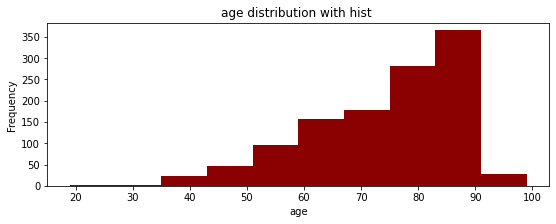

min CHD with no MI : 0 
max CHD with no MI : 1


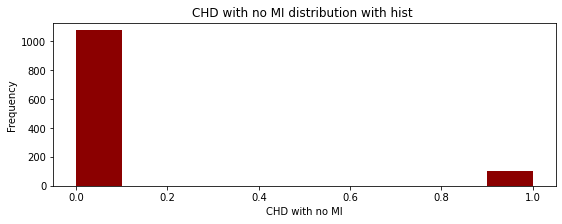

min Systolic blood pressure : 75.0 
max Systolic blood pressure : 203.0


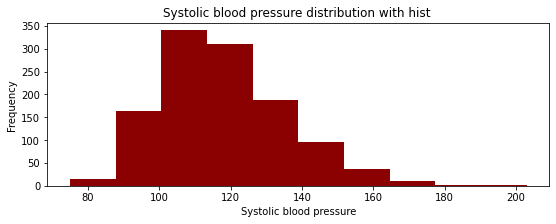

min Diastolic blood pressure : 24.73684211 
max Diastolic blood pressure : 107.0


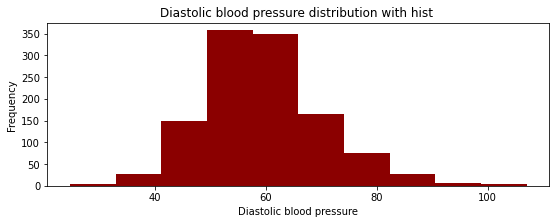

min Neutrophils : 5.0 
max Neutrophils : 98.0


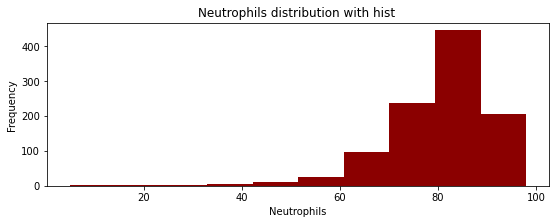

min EF : 15 
max EF : 75


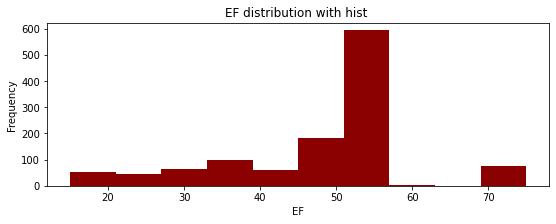

min Lactic acid : 0.5 
max Lactic acid : 8.333333332999999


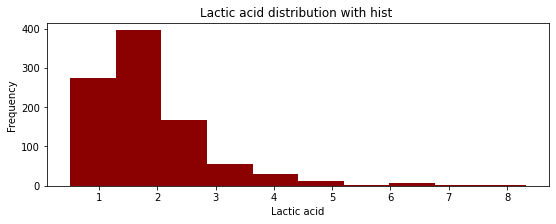

In [12]:
numericVar = ["age","CHD with no MI","Systolic blood pressure","Diastolic blood pressure","Neutrophils","EF","Lactic acid"]
for n in numericVar:
    plot_hist(n)

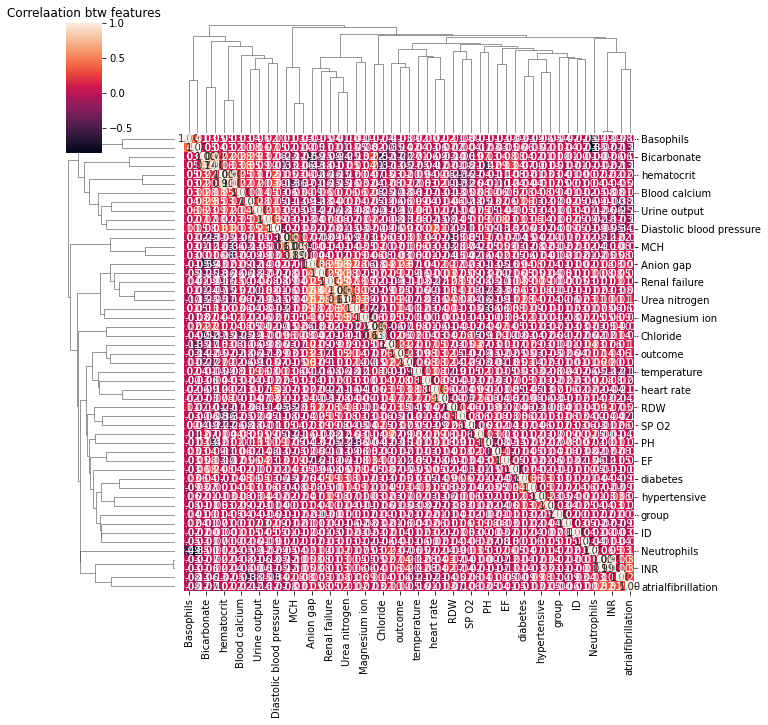

In [13]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlaation btw features")
plt.show()

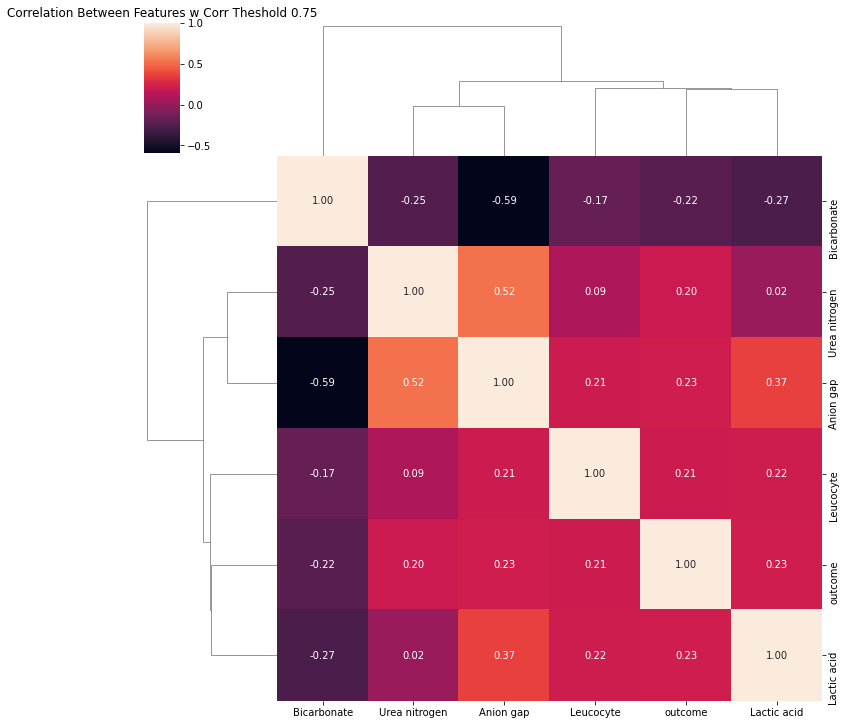

In [14]:
threshold = 0.2 
filtre = np.abs(corr_matrix["outcome"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(data[corr_features].corr(), annot = True, fmt = ".2f")
plt.title("Correlation Between Features w Corr Theshold 0.75")
plt.show()

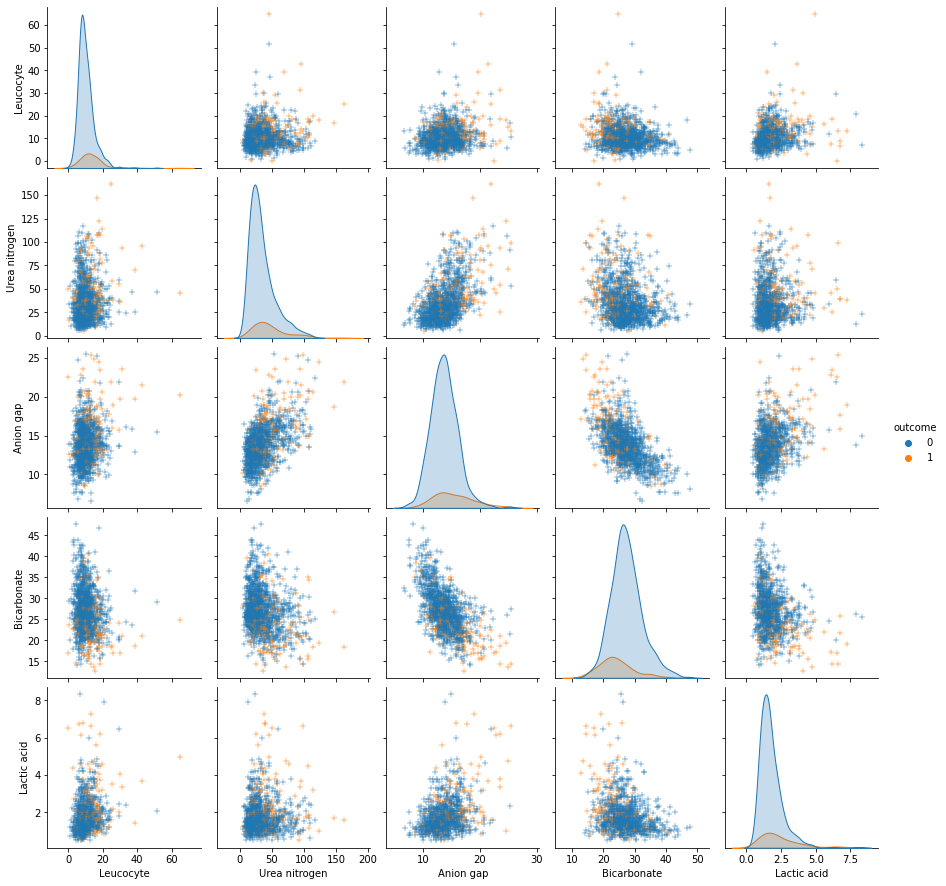

In [15]:
sns.pairplot(data[corr_features], diag_kind = "kde", markers = "+", hue = "outcome")
plt.show()

Outlier Detection

In [16]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    
    return multiple_outliers

In [17]:
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
Creatine kinase,25.075148
Basophils,10.165973
Creatinine,3.966716
COPD,3.210377
CHD with no MI,2.957589
INR,2.705281
PT,2.673359
Leucocyte,2.586018
Lymphocyte,2.470793
depression,2.354177


In [18]:
X = data.drop("outcome", axis = 1)
y = data.outcome

In [19]:
X.head()

,group,ID,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate,Systolic blood pressure,Diastolic blood pressure,Respiratory rate,temperature,SP O2,Urine output,hematocrit,RBC,MCH,MCHC,MCV,RDW,Leucocyte,Platelets,Neutrophils,Basophils,Lymphocyte,PT,INR,NT-proBNP,Creatine kinase,Creatinine,Urea nitrogen,glucose,Blood potassium,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,1,125047,72,1,37.588179,0,0,0,1,1,0,1,1,0,68.837838,155.866667,68.333333,16.621622,36.714286,98.394737,2155.0,26.272727,2.960000,28.250000,31.520000,89.900,16.220000,7.650000,305.100,74.65,0.40,13.3,10.600000,1.000000,1956.0,148.000000,1.958333,50.000000,114.636364,4.816667,138.750000,7.463636,109.166667,13.166667,2.618182,7.230,21.166667,0.5,40.0,55
1,1,139812,75,2,NaN,0,0,0,0,1,0,0,0,1,101.370370,140.000000,65.000000,20.851852,36.682540,96.923077,1425.0,30.780000,3.138000,31.060000,31.660000,98.200,14.260000,12.740000,246.400,NaN,NaN,NaN,NaN,NaN,2384.0,60.600000,1.122222,20.333333,147.500000,4.450000,138.888889,8.162500,98.444444,11.444444,1.887500,7.225,33.444444,0.5,78.0,55
2,1,109787,83,2,26.572634,0,0,0,0,1,0,0,1,0,72.318182,135.333333,61.375000,23.640000,36.453704,95.291667,2425.0,27.700000,2.620000,34.320000,31.300000,109.800,23.820000,5.480000,204.200,68.10,0.55,24.5,11.275000,0.950000,4081.0,16.000000,1.871429,33.857143,149.000000,5.825000,140.714286,8.266667,105.857143,10.000000,2.157143,7.268,30.571429,0.5,71.5,35
3,1,130587,43,2,83.264629,0,0,0,0,0,0,0,0,0,94.500000,126.400000,73.200000,21.857143,36.287037,93.846154,8760.0,36.637500,4.277500,26.062500,30.412500,85.625,17.037500,8.225000,216.375,81.80,0.15,14.5,27.066667,2.666667,668.0,85.000000,0.585714,15.285714,128.250000,4.386667,138.500000,9.476923,92.071429,12.357143,1.942857,7.370,38.571429,0.6,75.0,55
4,1,138290,75,2,31.824842,1,0,0,0,1,0,0,1,1,67.920000,156.560000,58.120000,21.360000,36.761905,99.280000,4455.0,29.933333,3.286667,30.666667,33.666667,91.000,16.266667,8.833333,251.000,NaN,NaN,NaN,NaN,NaN,30802.0,111.666667,1.950000,43.000000,145.750000,4.783333,136.666667,8.733333,104.500000,15.166667,1.650000,7.250,22.000000,0.6,50.0,55


In [20]:
print("Before Smote")
y.value_counts()

Before Smote


0    1018
1     159
Name: outcome, dtype: int64

In [21]:
print("Before Smote")
X.value_counts()

Before Smote


group  ID      age  gendera  BMI        hypertensive  atrialfibrillation  CHD with no MI  diabetes  deficiencyanemias  depression  Hyperlipemia  Renal failure  COPD  heart rate  Systolic blood pressure  Diastolic blood pressure  Respiratory rate  temperature  SP O2      Urine output  hematocrit  RBC       MCH        MCHC       MCV        RDW        Leucocyte  Platelets   Neutrophils  Basophils  Lymphocyte  PT         INR       NT-proBNP  Creatine kinase  Creatinine  Urea nitrogen  glucose     Blood potassium  Blood sodium  Blood calcium  Chloride    Anion gap  Magnesium ion  PH        Bicarbonate  Lactic acid  PCO2       EF
2      199925  86   1        20.415225  1             1                   0               0         0                  0           0             1              0     77.590909   117.047619               56.761905                 24.909091         37.044444    95.809524  1770.0        35.377778   3.866667  31.255556  34.166667  91.666667  13.566667  16.066667  268.66

In [22]:
!pip install imblearn

Counter({0: 9900, 1: 100})
Counter({0: 9900, 1: 9900})


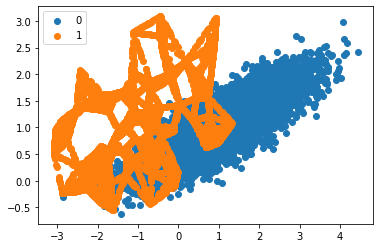

In [23]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [24]:
import imblearn
print(imblearn.__version__)

0.8.1


In [25]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = test_size)

In [26]:
print("X_train shape {}, len {}.".format(X_train.shape,len(X_train)))
print("X_test shape {}, len {}.".format(X_test.shape,len(X_test)))
print("Y_train shape {}, len {}.".format(Y_train.shape,len(Y_train)))
print("Y_test shape {}, len {}.".format(Y_test.shape,len(Y_test)))

X_train shape (13860, 2), len 13860.
X_test shape (5940, 2), len 5940.
Y_train shape (13860,), len 13860.
Y_test shape (5940,), len 5940.


In [27]:
# list to keep our results
result_acc = []

X-GBoost

In [28]:
XGB = XGBClassifier(max_depth = 1)
XGB.fit(X_train, Y_train)
y_pred_xgb = XGB.predict(X_test)
cm_xgb = confusion_matrix(y_pred_xgb, Y_test)
acc_xgb = accuracy_score(Y_test, y_pred_xgb)
result_acc.append(acc_xgb)
print("RESULT")
print("XGBoost Model Acc : ",acc_xgb)
print("XGBoost Model Cm : ",cm_xgb)

RESULT
XGBoost Model Acc :  0.915993265993266
XGBoost Model Cm :  [[2724  293]
 [ 206 2717]]


In [49]:
print('Training set score: {:.4f}'.format(XGB.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(XGB.score(X_test, Y_test)))

Training set score: 0.9160
Test set score: 0.9160


CAT-Boost



In [30]:
best_params = {'bagging_temperature': 0.8,
               'depth': 5,
               'iterations': 500,
               'l2_leaf_reg': 30,
               'learning_rate': 0.05,
               'random_strength': 0.8}

model_cat_boost = CatBoostClassifier(
        **best_params,
        loss_function='Logloss',
        eval_metric='Accuracy',         
        nan_mode='Min',
        verbose=False
    )

model_cat_boost.fit(
        X_train, Y_train,
        verbose_eval=100, 
        early_stopping_rounds=60,
        eval_set=(X_test, Y_test),
        use_best_model=False,
        plot=True
)

y_pred_cat_boost = model_cat_boost.predict(X_test)

cm_cat_boost = confusion_matrix(y_pred_cat_boost, Y_test)
acc_cat_boost = accuracy_score(Y_test, y_pred_cat_boost)
result_acc.append(acc_cat_boost)
print("RESULT")
print("Cat Boost Model Acc : ",acc_cat_boost)
print("Cat Boost Model Cm : ",cm_cat_boost)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9042569	test: 0.8974747	best: 0.8974747 (0)	total: 62.4ms	remaining: 31.1s
100:	learn: 0.9312410	test: 0.9286195	best: 0.9289562 (96)	total: 677ms	remaining: 2.68s
200:	learn: 0.9383838	test: 0.9348485	best: 0.9348485 (195)	total: 1.36s	remaining: 2.03s
300:	learn: 0.9422078	test: 0.9370370	best: 0.9375421 (249)	total: 1.85s	remaining: 1.22s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.9375420875
bestIteration = 249

RESULT
Cat Boost Model Acc :  0.9368686868686869
Cat Boost Model Cm :  [[2776  221]
 [ 154 2789]]


In [31]:
print('Training set score: {:.4f}'.format(model_cat_boost.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(model_cat_boost.score(X_test, Y_test)))

Training set score: 0.9424
Test set score: 0.9369


ROC & AUC Curve for X-Gboost

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

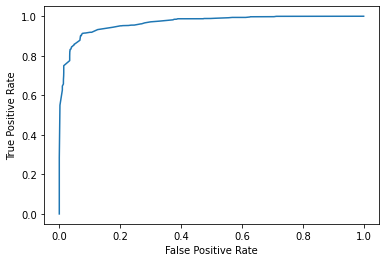

In [33]:
y_pred_proba = XGB.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

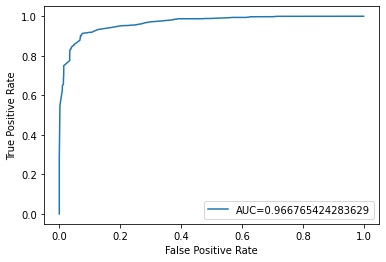

In [34]:
y_pred_proba = XGB.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

ROC & AUC Curve for CatBoost

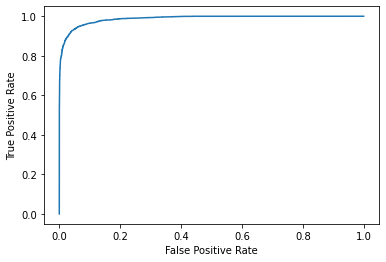

In [35]:
y_pred_proba = model_cat_boost.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

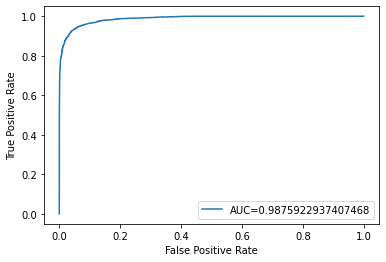

In [36]:
y_pred_proba = model_cat_boost.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_train,  y_pred_proba)
auc = metrics.roc_auc_score(Y_train, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Logistic Regrission

In [37]:
log_reg_model = LogisticRegression(random_state=42, penalty='l2', C=0.1)
log_reg_model.fit(X_train, Y_train)

LogisticRegression(C=0.1, random_state=42)

In [38]:
y_pred = log_reg_model.predict(X_test)
y_pred_prob = log_reg_model.predict_proba(X_test)

In [39]:
print('Accuracy Score:', accuracy_score(Y_test, y_pred))



Accuracy Score: 0.9112794612794612


**Light GBM**

In [40]:
!pip install lightgbm

In [41]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(X_train, Y_train)

LGBMClassifier()

In [42]:
y_pred=clf.predict(X_test)

In [43]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, Y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, y_pred)))

LightGBM Model accuracy score: 0.9431


In [44]:
y_pred_train = clf.predict(X_train)

In [45]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(Y_train, y_pred_train)))

Training-set accuracy score: 0.9530


In [46]:
print('Training set score: {:.4f}'.format(clf.score(X_train, Y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, Y_test)))

Training set score: 0.9530
Test set score: 0.9431


In [47]:
results=pd.DataFrame(columns=['score'])
results.loc['X-Gboost']=[acc_xgb]
results.loc['Cat-boost']=[acc_cat_boost]
results.loc['LightGBM']=[accuracy]

In [48]:
results.sort_values('score',ascending=False).style.background_gradient(cmap='Greens',subset=['score'])

,score
LightGBM,0.943098
Cat-boost,0.936869
X-Gboost,0.915993
